## Serve a model with TensorFlow Serving



In [1]:
import os
import zipfile
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from IPython.display import Image, display
import tempfile
import json
import requests

#### Load Data

In [2]:
mnist= tf.keras.datasets.mnist

In [3]:
(x_train, y_train), (x_test, y_test)= mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#### Normalization

In [4]:
x_train= x_train/255.0
x_test= x_test/255.0

#### Add a channel information

In [5]:
x_train= x_train.reshape(x_train.shape[0],28,28,1)
x_test= x_test.reshape(x_test.shape[0],28,28,1)

In [6]:
print('\n x_train.shape: {}, of {}'.format(x_train.shape, x_train.dtype))
print('\n x_test.shape: {}, of {}'.format(x_test.shape, x_test.dtype))


 x_train.shape: (60000, 28, 28, 1), of float64

 x_test.shape: (10000, 28, 28, 1), of float64


#### Take a look to data

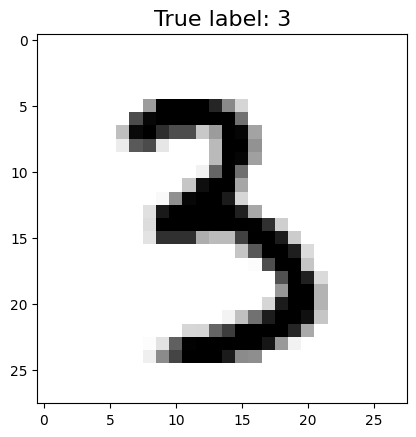

In [7]:
idx= 32
plt.imshow(x_test[idx].reshape(28,28), cmap=plt.cm.binary)
plt.title('True label: {}'.format(y_test[idx]), fontdict={'size':16})
plt.show()

#### Create Model

In [8]:
model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3,
                           strides=2, activation='relu', name='Conv1'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation= tf.nn.softmax, name='Softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Softmax (Dense)             (None, 10)                13530     
                                                                 
Total params: 13610 (53.16 KB)
Trainable params: 13610 (53.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Compile the model

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=5

history= model.fit(x_train, y_train, epochs= epochs)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.3770 - accuracy: 0.8950
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2269 - accuracy: 0.9364
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1769 - accuracy: 0.9502
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1490 - accuracy: 0.9574
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1266 - accuracy: 0.9639


#### Evaluation

In [10]:
results_eval= model.evaluate(x_test, y_test, verbose=0)

for metric, value in zip(model.metrics_names, results_eval):
  print(metric + ':{:.3}'.format(value))

loss:0.12
accuracy:0.963


#### Save the model to use tensorflow model serving on it

In [11]:
MODEL_DIR= tempfile.gettempdir()
version=1
export_path= os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
  !rm -r {export_path}

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

In [12]:
print(f'\nFiles of model saved in {export_path }:\n')
!ls -lh {export_path}


Files of model saved in /tmp/1:

total 100K
drwxr-xr-x 2 root root 4.0K Dec 20 19:52 assets
-rw-r--r-- 1 root root   57 Dec 20 19:52 fingerprint.pb
-rw-r--r-- 1 root root 8.5K Dec 20 19:52 keras_metadata.pb
-rw-r--r-- 1 root root  75K Dec 20 19:52 saved_model.pb
drwxr-xr-x 2 root root 4.0K Dec 20 19:52 variables


In [13]:
!saved_model_cli show --dir {export_path} --tag_set serve --signature_def serving_default

2023-12-20 19:52:30.682904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 19:52:30.682944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 19:52:30.683960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 19:52:31.742602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['Conv1_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 28, 28, 1)
      name: serving_default_Conv1_input:0
The given SavedModel SignatureDef contains t

#### Serve the model
##### Load tensorflow-model-server

In [14]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2023-12-20 19:52:33--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c03::cf, 2607:f8b0:4023:c0b::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 319.88M  55.6MB/s    in 6.4s    

2023-12-20 19:52:40 (50.3 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb’ saved [335421916/335421916]

Selecting previously unselected package tensorflow-model-server-universal.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.

##### Configure the server

In [15]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [16]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=mnist_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [17]:
!tail server.log

##### Make requests to the model with json

In [18]:
test_imgs_list = x_test.tolist()
data= json.dumps({"instances":test_imgs_list})

In [19]:
headers = {"content-type": "application/json"}

##### Take the responses from the model

In [20]:
json_response = requests.post('http://localhost:8501/v1/models/mnist_model:predict', data=data, headers=headers)
print( json_response.text)
predictions = json.loads(json_response.text)['predictions']
#print(f"predictions has shape: {np.asarray(predictions).shape}")

{
    "predictions": [[1.66929112e-07, 1.06018035e-10, 3.15286206e-06, 0.000150591542, 7.79074e-11, 1.24911981e-09, 8.54278367e-12, 0.999840856, 9.20324567e-07, 4.29938564e-06], [4.20010292e-06, 5.17608096e-05, 0.999935269, 2.24598466e-06, 5.96444958e-14, 1.49201605e-06, 4.43529234e-06, 2.01556043e-15, 5.58752106e-07, 9.40823916e-13], [2.12458599e-05, 0.998184264, 0.000666280044, 4.32055713e-05, 0.000143637939, 2.96786166e-05, 0.000262832065, 0.000326545589, 0.000285960152, 3.63429281e-05], [0.999801338, 2.49102055e-08, 7.15481729e-05, 2.05816349e-07, 2.54159204e-07, 2.26034081e-05, 5.23441631e-05, 7.25084237e-06, 3.74953343e-05, 7.0661049e-06], [3.30021867e-05, 7.32843819e-06, 6.92050744e-05, 3.44324e-07, 0.998874843, 4.5260748e-07, 6.57352866e-05, 0.000516845437, 0.000174500659, 0.000257686537], [9.82464735e-06, 0.997621, 0.000390709756, 4.39877e-05, 6.09114468e-05, 3.13951705e-06, 1.51434433e-05, 0.00140020053, 0.000359415426, 9.56593285e-05], [1.31683146e-06, 7.09236701e-05, 2.2180

##### Check the results

In [21]:
preds = np.argmax(predictions, axis=1)
print(f"preds has shape: {preds.shape}")

preds has shape: (10000,)


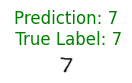

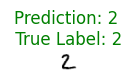

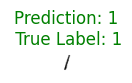

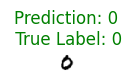

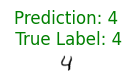

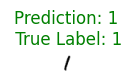

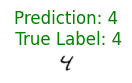

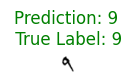

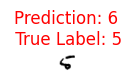

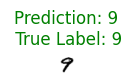

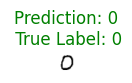

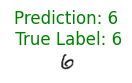

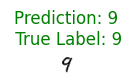

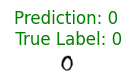

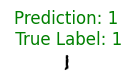

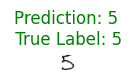

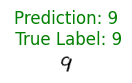

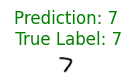

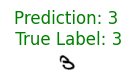

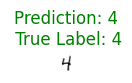

In [22]:
for i in range(20):
  plt.subplot(1,20,i+1)
  plt.imshow(x_test[i].reshape(28,28), cmap=plt.cm.binary)
  plt.axis('off')
  color= 'green' if preds[i]== y_test[i] else 'red'
  plt.title('Prediction: {}\n True Label: {}'.format(preds[i], y_test[i]), color= color)
  plt.show()